In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
# import pyximport
# pyximport.install()
sys.path.append('../')
from QRT.RegressionTreeQuantile import RegressionTreeQuantile
from CRPStreeC.entropies_CRPS import entropies_CRPS
from CRPStreeC.RegressionTree import RegressionTree
from CRPStreeC.get_entropy import get_entropy
import pandas as pd
import random

import scipy 

In [2]:
import CRPS.CRPS as pscore
import properscoring as ps

def get_entropy(vals):
    values = np.sort(vals)
    h = 0
    n = len(values)
    for i in range(1,n+1):
        h += i*(i-1)*(values[i-1]-values[n-i])
    return h/(n)**3

In [3]:
import itertools
def compute_expression(y):
    n = len(y)
    if n < 3:
        return 0
    
    y_sorted = sorted(y)
    
    sum_1 = 0
    sum_2 = 0
    
    # First sum: i < j < k
    for i, j, k in itertools.combinations(range(n), 3):
        sum_1 += (y_sorted[j] - y_sorted[i])
    
    # Second sum: j < k < i
    for j, k, i in itertools.combinations(range(n), 3):
        sum_2 += (y_sorted[i] - y_sorted[k])
    
    result = (2 / n**3) * (sum_1 + sum_2)
    
    return result*(n/(n-2))

In [9]:
if True:
    y = np.array(list(np.random.normal(0,3, 50)) + list(np.random.normal(1,3, 50)))

    import random
    random.shuffle(y)
else:
    y = np.array([5,3,7,6,2,4,8,1])

true_crps  = [0]
true_crps2 = [0]
true_crps3 = [0]
true_crps4 = [0]
for i in range(1,len(y)+1):
    true_crps.append(0)
    true_crps3.append(0)
    for j in range(i):
        crps,fcrps,acrps = pscore(y[:i],y[j]).compute()
        true_crps[-1] += crps /(i)
        true_crps3[-1] += ps.crps_ensemble(y[j], y[:i])/(i) 
    true_crps2.append(get_entropy(y[:i]))
    true_crps4.append(compute_expression(y[:i]))

In [10]:
n = len(y)
CRPS = 0
ysort = np.sort(y)
for ob in y:
    cdf_fc = np.linspace(1/n,1,n)
    cdf_ob = (ysort >= ob)
    all_mem = ysort
    delta_fc = np.array([all_mem[n+1] - all_mem[n] for n in range(len(all_mem)-1)] + list(np.zeros(1)), dtype=object) 
    crps = np.sum(np.array((cdf_fc - cdf_ob) ** 2)*delta_fc)
    CRPS += crps / len(y)
print(CRPS, true_crps[-1], true_crps4[-1])

1.6466113118241148 1.6466113118241148 1.6466113118240266


In [11]:
order = np.array([i for i in range(len(y))]).astype(int)
entropies = entropies_CRPS(order, y, use_LOO=False)

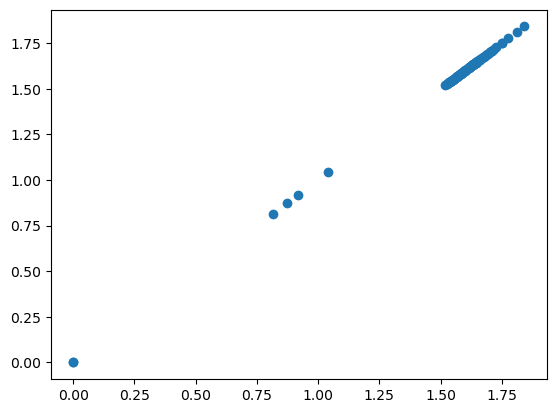

In [12]:
plt.scatter(entropies, true_crps)

In [11]:
idx = 4
while idx <= 10:
    idx += idx & -idx
    print(idx)

8
16


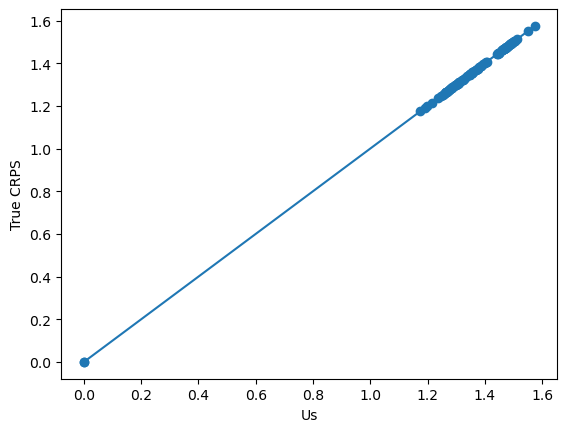

In [8]:
a = true_crps2
b = true_crps
plt.scatter(a, b)
plt.xlabel('Us')
plt.ylabel('True CRPS')
m = min([np.min(a), np.min(b)])
M = max([np.max(a), np.max(b)])
plt.plot([m,M],[m,M])

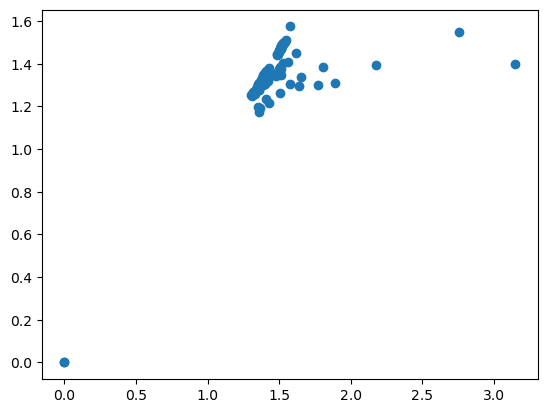

In [9]:
plt.scatter(entropies, true_crps)

In [15]:
entropies[:5], true_crps[:5], true_crps4[:5]

(array([0.        , 0.        , 1.08034692, 0.96030838, 1.39537265]),
 [0, 0.0, 1.0803469229723088, 0.9603083759753857, 1.3953726491709273],
 [0, 0, 0, 0.9603083759753857, 1.3953726491709273])

# Timer

In [13]:
time_bruteforce = []
time_us = []
ls_n = [25*i for i in range(1,26)]
for n in ls_n:
    y = np.random.normal(0, 1, n)
    #y = np.array(list(np.random.normal(0,3, 50)) + list(np.random.normal(1,3, 50)))
    import random
    from time import time
    random.shuffle(y)

    true_crps  = [0]
    true_crps3 = [0]

    t0 = time()
    for i in range(1,len(y)+1):
        true_crps.append(0)
        true_crps3.append(0)
        for j in range(i):
            crps,fcrps,acrps = pscore(y[:i],y[j]).compute()
            #true_crps3[-1] += ps.crps_ensemble(y[j], y[:i])/(i)
    t1 = time()
    time_bruteforce.append(t1-t0)
    order = np.array([i for i in range(len(y))]).astype(int)
    t0 = time()
    entropies = entropies_CRPS(order, y)
    t1 = time()
    time_us.append(t1-t0)

In [10]:
time_us = np.zeros(len(ls_n))
for i_n, n in enumerate(ls_n):
    for ite in range(20):
        y = np.random.normal(0, 1, n)
        #y = np.array(list(np.random.normal(0,3, 50)) + list(np.random.normal(1,3, 50)))
        import random
        from time import time
        random.shuffle(y)

        order = np.array([i for i in range(len(y))]).astype(int)
        t0 = time()
        entropies = entropies_CRPS(order, y)
        t1 = time()
        time_us[i_n] += (t1-t0)/20

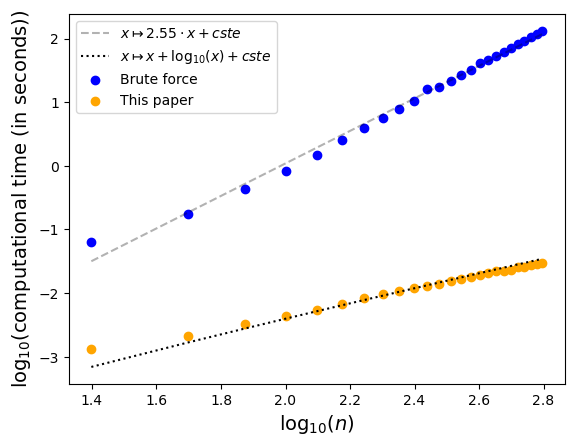

In [23]:
plt.scatter(np.log10(ls_n), np.log10(time_bruteforce), label='Brute force', color='blue')
plt.scatter(np.log10(ls_n), np.log10(time_us), label='This paper', color='orange')
y = np.log10(time_bruteforce)
x = np.concatenate((np.log10(ls_n).reshape(-1,1), np.ones((len(y), 1))), axis=1)
beta = np.linalg.inv(x.T @ x) @ x.T @ y
plt.plot(np.log10(ls_n), x @ beta, color='black', alpha=0.3, linestyle='--', label='$x\mapsto  {0}\cdot x+cste$'.format(str(np.round(beta[0],2))))
# plt.plot(np.log10(ls_n), np.log10(time_us), color='orange', linestyle='--')
# plt.plot(np.log10(ls_n), np.log10(time_bruteforce), color='blue', linestyle='--')
y = np.log10(time_us)
x = np.concatenate((np.log10(ls_n).reshape(-1,1), np.ones((len(y), 1))), axis=1)
beta = np.linalg.inv(x.T @ x) @ x.T @ y
#plt.plot(np.log10(ls_n), x @ beta, color='black', linestyle=':', label='Slope = {0}'.format(str(np.round(beta[0],2))))
vals=np.log10(ls_n*np.log10(ls_n))
plt.plot(np.log10(ls_n), vals-np.mean(vals)+np.mean(y) , color='black', linestyle=':', label='$x\mapsto x+ \log_{10}(x)+cste$')

plt.xlabel('$\log_{10}(n)$', fontsize=14)
plt.ylabel('$\log_{10}$(computational time (in seconds))', fontsize=14)
plt.legend()
plt.savefig('compute_time_white_gaussian.png', dpi=250, bbox_inches='tight')
plt.show()